In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import scipy.stats as sps
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm

In [2]:
def plot_insights(directory: str):
    data = np.load(f"outputs/{directory}/losses.npy")
    epochs = 0
    for i in range(data.shape[0]):
        if np.count_nonzero(data[i]) > 0:
            epochs += 1
            
    data = data[:epochs, :]
    
    true_labels = np.load(f'outputs/{directory}/true_labels.npy')
    corrupted_labels = np.load(f'outputs/{directory}/corrupted_labels.npy')
    labels_history = np.load(f'outputs/{directory}/labels_history.npy')[:epochs, :]
    val_accuracies = np.load(f'outputs/{directory}/val_accuracies.npy')[:epochs]
    train_accuracies = np.load(f'outputs/{directory}/train_accuracies.npy')[:epochs]
    train_predictions = np.load(f'outputs/{directory}/train_predictions.npy')[:epochs, :]
    is_corrupted = labels_history != true_labels[None, :]
    
    wds = []
    intersections = []
    gmm_diffs = []

    corrupted_fraction = (labels_history == true_labels).sum(axis=1) / labels_history.shape[1]
    corrupted_fraction = 1 - corrupted_fraction
    
    avg_loss = np.clip(data, 0, np.quantile(data, 0.99)).mean(axis=0)
    
    k, m = 4, 3
    fig, ax = plt.subplots(k, m, figsize=(12, 8))
    for i in range(k):
        for j in range(m):
            n = i * m + j
            epoch = min(int(n * (epochs / (k * m))), epochs - 1)
            clipped_data = data[epoch, :]
            clipped_data = np.clip(clipped_data, 0, np.quantile(clipped_data, 0.995))
            clipped_data = (clipped_data - np.mean(clipped_data)) / np.std(clipped_data)
            
            bins = np.linspace(min(clipped_data), max(clipped_data), 50)
            
            h1, _, _ = ax[i, j].hist(clipped_data[~is_corrupted[epoch]], bins=bins, alpha=0.5, label='Clean Labels', density=True)
            h2, _, _ = ax[i, j].hist(clipped_data[is_corrupted[epoch]], bins=bins, alpha=0.5, label='Corrupted Labels', density=True)
            ax[i, j].set_title(f'Epoch {epoch}')
            
            q4 = np.quantile(np.concat([h1, h2]), 0.75)
            q1 = np.quantile(np.concat([h1, h2]), 0.25)
            iqr = q4 - q1
            upper_bound = q4 + 10 * iqr
            ax[i, j].set_ylim(0, min(upper_bound, max(h1.max(), h2.max()) * 1.1))
            
            if i == 0 and j == 0:
                handles, labels = ax[i, j].get_legend_handles_labels()
                
            gmm = GaussianMixture(n_components=2, covariance_type='diag')
            no_outliers_data = clipped_data[clipped_data < np.quantile(clipped_data, 0.975)]
            gmm.fit(no_outliers_data.reshape(-1, 1))
            
            mu1, sigma1 = gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0])
            mu2, sigma2 = gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0])
            if mu1 > mu2:
                mu1, sigma1, mu2, sigma2 = mu2, sigma2, mu1, sigma1
                
            x = np.linspace(min(clipped_data), max(clipped_data), 100)
            ax[i, j].plot(x, sps.norm(mu1, sigma1).pdf(x), color='blue')
            ax[i, j].plot(x, sps.norm(mu2, sigma2).pdf(x), color='red')
    
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.01))
    
    plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.95])
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()
    
    corr_pred_precisions = []
    corr_pred_recalls = []
    for epoch in tqdm(range(epochs)):
        scaled_data = data[epoch, :]
        scaled_data = (scaled_data - np.mean(scaled_data)) / np.std(scaled_data)
        wd = wasserstein_distance(scaled_data[~is_corrupted[epoch]], scaled_data[is_corrupted[epoch]])
        wds.append(wd)
        
        clipped_data = np.clip(
            scaled_data,
            np.quantile(scaled_data, 0.01),
            np.quantile(scaled_data, 0.99)
        )
        bins = np.linspace(min(clipped_data), max(clipped_data), 50)
        h_clean = np.histogram(clipped_data[~is_corrupted[epoch]], bins=bins, density=True)[0]
        h_corrupted = np.histogram(clipped_data[is_corrupted[epoch]], bins=bins, density=True)[0]
        intersection = np.sum(np.minimum(h_clean, h_corrupted))
        intersection /= np.sum(h_clean)
        intersections.append(intersection)
        
        no_outliers_data = scaled_data[scaled_data < np.quantile(scaled_data, 0.95)]
        
        gmm = GaussianMixture(n_components=2, covariance_type='diag')
        gmm.fit(no_outliers_data.reshape(-1, 1))
        mu1, sigma1 = gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0])
        mu2, sigma2 = gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0])
        if mu1 > mu2:
            mu1, sigma1, mu2, sigma2 = mu2, sigma2, mu1, sigma1
        
        gmm_intersection = np.sum(np.minimum(
            sps.norm(mu1, sigma1).pdf(bins),
            sps.norm(mu2, sigma2).pdf(bins)
        )) / np.sum(sps.norm(mu1, sigma1).pdf(bins))
        gmm_diffs.append(gmm_intersection)
        
        d_clean = sps.norm(mu1, sigma1)
        d_corrupted = sps.norm(mu2, sigma2)
        def corrupted_probability(loss):
            return d_corrupted.pdf(loss) * 0.4 / (0.6 * d_clean.pdf(loss) + 0.4 * d_corrupted.pdf(loss) + 1e-10)
        probas = corrupted_probability(scaled_data)
        threshold = 0.95
        predicted_corrupted = probas > threshold
        corruption_pred_precision = (is_corrupted[epoch] & predicted_corrupted).sum() / predicted_corrupted.sum()
        corruption_pred_recall = (is_corrupted[epoch] & predicted_corrupted).sum() / is_corrupted[epoch].sum()
        corr_pred_precisions.append(corruption_pred_precision)
        corr_pred_recalls.append(corruption_pred_recall)
        
    
    _, ax = plt.subplots(5, 2, figsize=(10, 13))
    ax[0, 0].plot(val_accuracies)
    ax[0, 0].set_title('Validation Accuracy')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 1].plot(corrupted_fraction)
    ax[0, 1].set_title('Corrupted Fraction')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Fraction')
    
    avg_loss_corrupted = data[:, is_corrupted[epoch]].mean(axis=1)
    avg_loss_clean = data[:, ~is_corrupted[epoch]].mean(axis=1)
    ax[1, 0].plot(avg_loss_corrupted, label='Corrupted')
    ax[1, 0].plot(avg_loss_clean, label='Clean')
    ax[1, 0].set_title('Average Loss')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend()
    
    ax[1, 1].plot(gmm_diffs)
    ax[1, 1].set_title('GMM Intersection')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Intersection')
    
    ax[2, 0].plot(train_accuracies)
    ax[2, 0].set_title('Train Accuracy')
    ax[2, 0].set_xlabel('Epoch')
    ax[2, 0].set_ylabel('Accuracy')
    
    misclassified = (
        train_predictions == corrupted_labels.reshape(1, -1)
    )[:, is_corrupted[0]].sum(axis=1)/ is_corrupted[0].sum()
    correct = (
        train_predictions == true_labels.reshape(1, -1)
    )[:, is_corrupted[0]].sum(axis=1) / is_corrupted[0].sum()
    incorrect = (
        (train_predictions != true_labels.reshape(1, -1)) & (train_predictions != corrupted_labels.reshape(1, -1))
    )[:, is_corrupted[0]].sum(axis=1) / is_corrupted[0].sum()
    ax[2, 1].plot(misclassified, label='Misclassified')
    ax[2, 1].plot(correct, label='Correct')
    ax[2, 1].plot(incorrect, label='Incorrect')
    ax[2, 1].set_title('Train Predictions on corrupted data')
    ax[2, 1].legend()
    ax[2, 1].set_xlabel('Epoch')
    ax[2, 1].set_ylabel('Count')
    
    ax[3, 0].plot(wds)
    ax[3, 0].set_title('Wasserstein Distance Clean/Corrupted')
    ax[3, 0].set_ylabel('Wasserstein Distance')
    ax[3, 0].set_xlabel('Epoch')
    
    ax[3, 1].plot(intersections)
    ax[3, 1].set_title('Intersection of Histograms')
    ax[3, 1].set_ylabel('Intersection')
    ax[3, 1].set_xlabel('Epoch')
    
    ax[4, 0].plot(corr_pred_precisions, label='Precision')
    ax[4, 0].plot(corr_pred_recalls, label='Recall')
    ax[4, 0].set_title('Corruption Prediction')
    ax[4, 0].set_ylabel('Score')
    ax[4, 0].set_xlabel('Epoch')
    ax[4, 0].legend()
    
    ax[4, 1].set_visible(False)
    
    
    plt.tight_layout()
    plt.show()
    

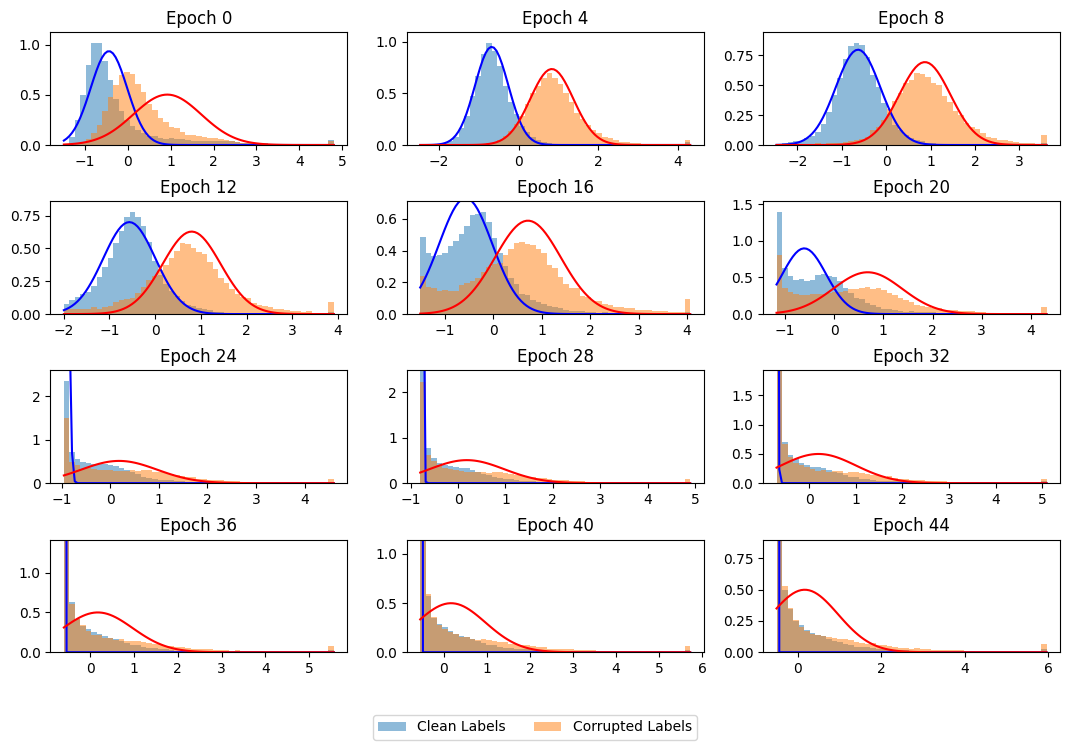

  0%|          | 0/48 [00:00<?, ?it/s]

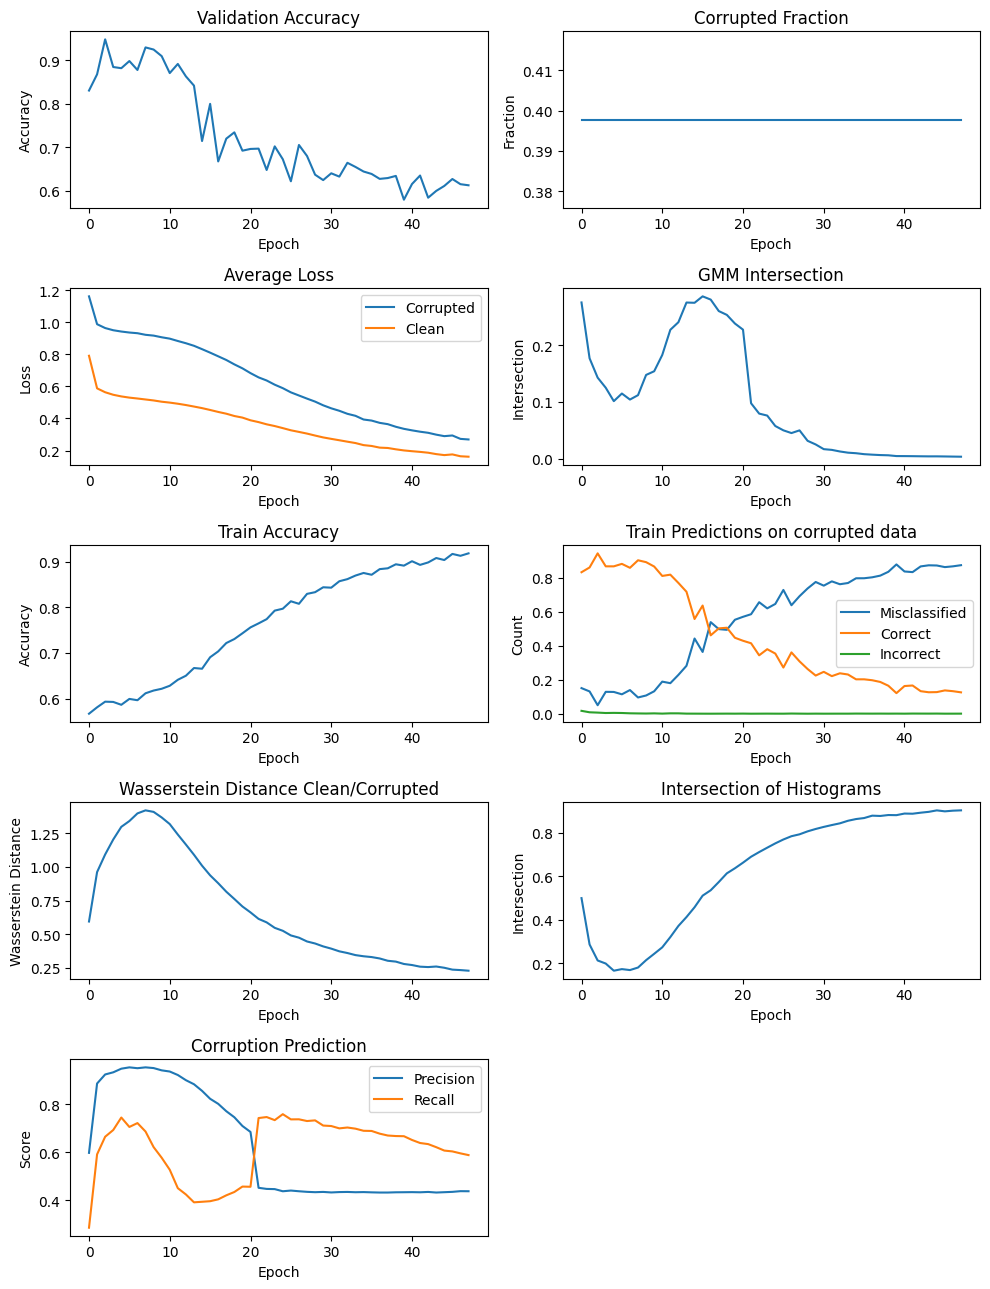

In [16]:
plot_insights('adamw_mnist_base')

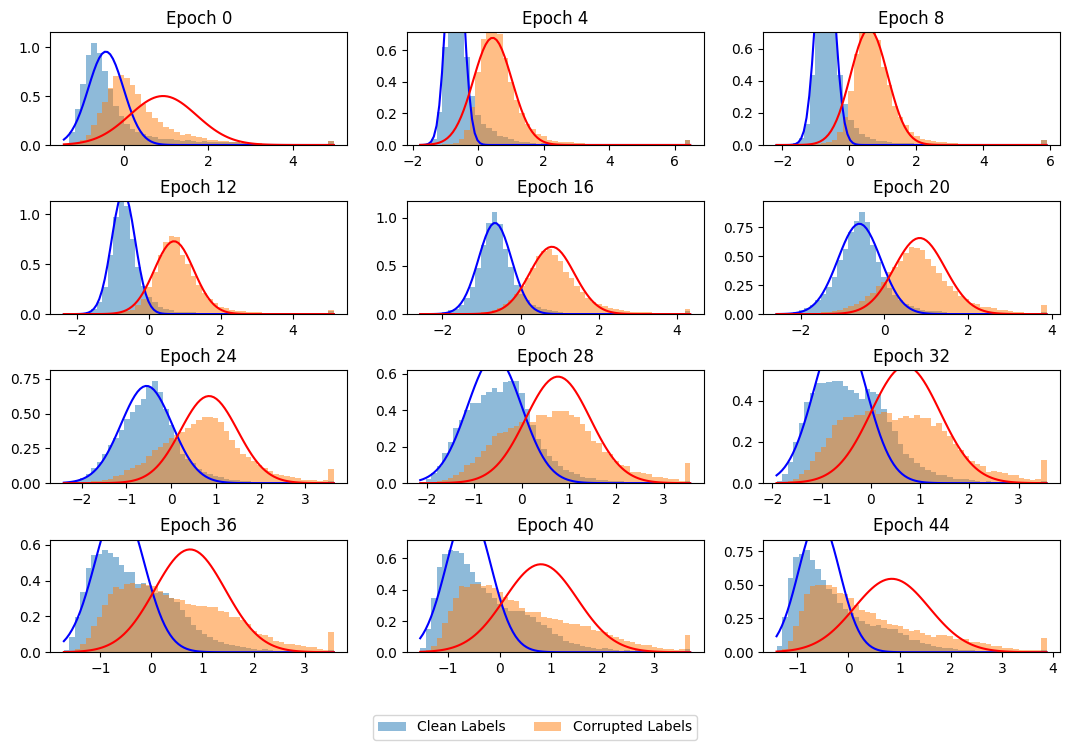

  0%|          | 0/48 [00:00<?, ?it/s]

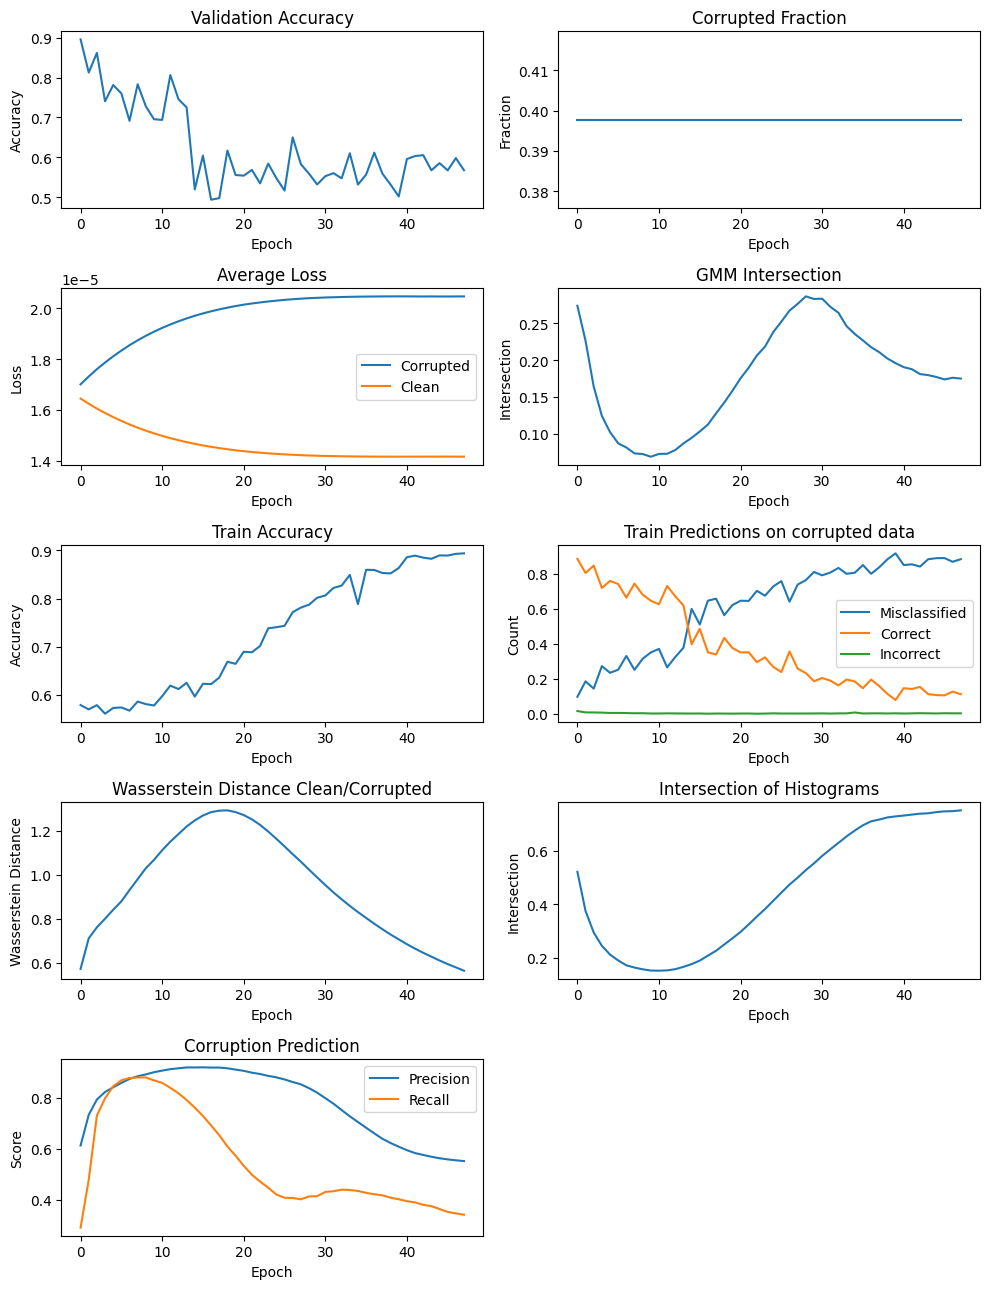

In [17]:
plot_insights('adversarial_mnist_base')

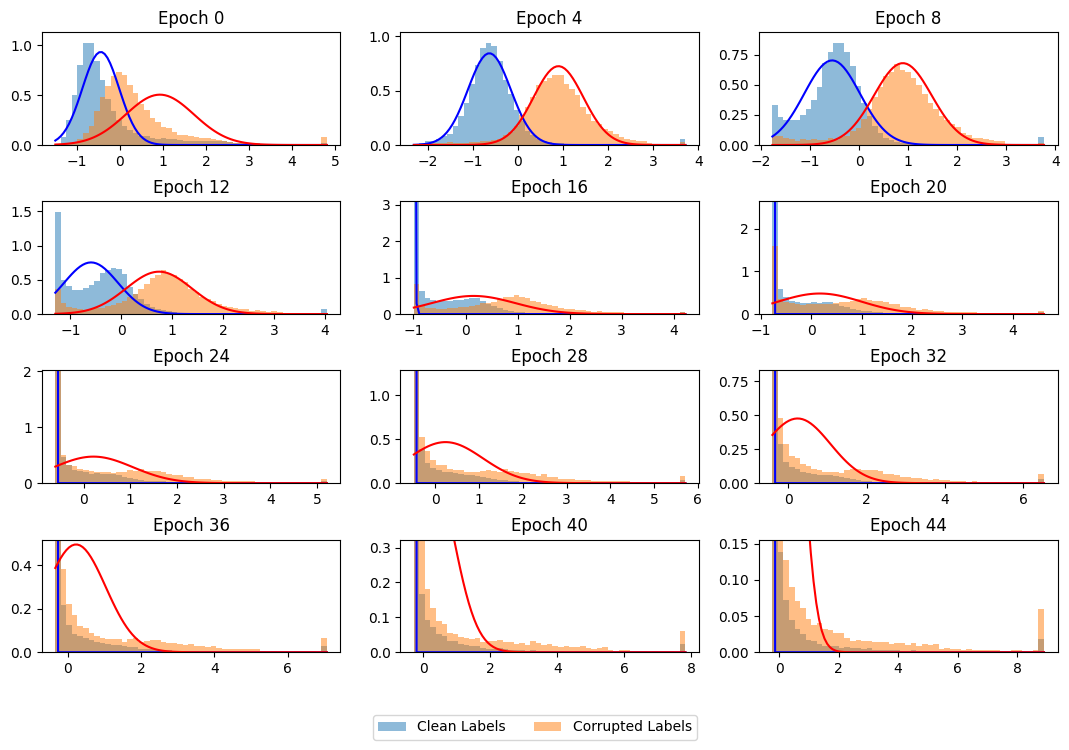

  0%|          | 0/48 [00:00<?, ?it/s]

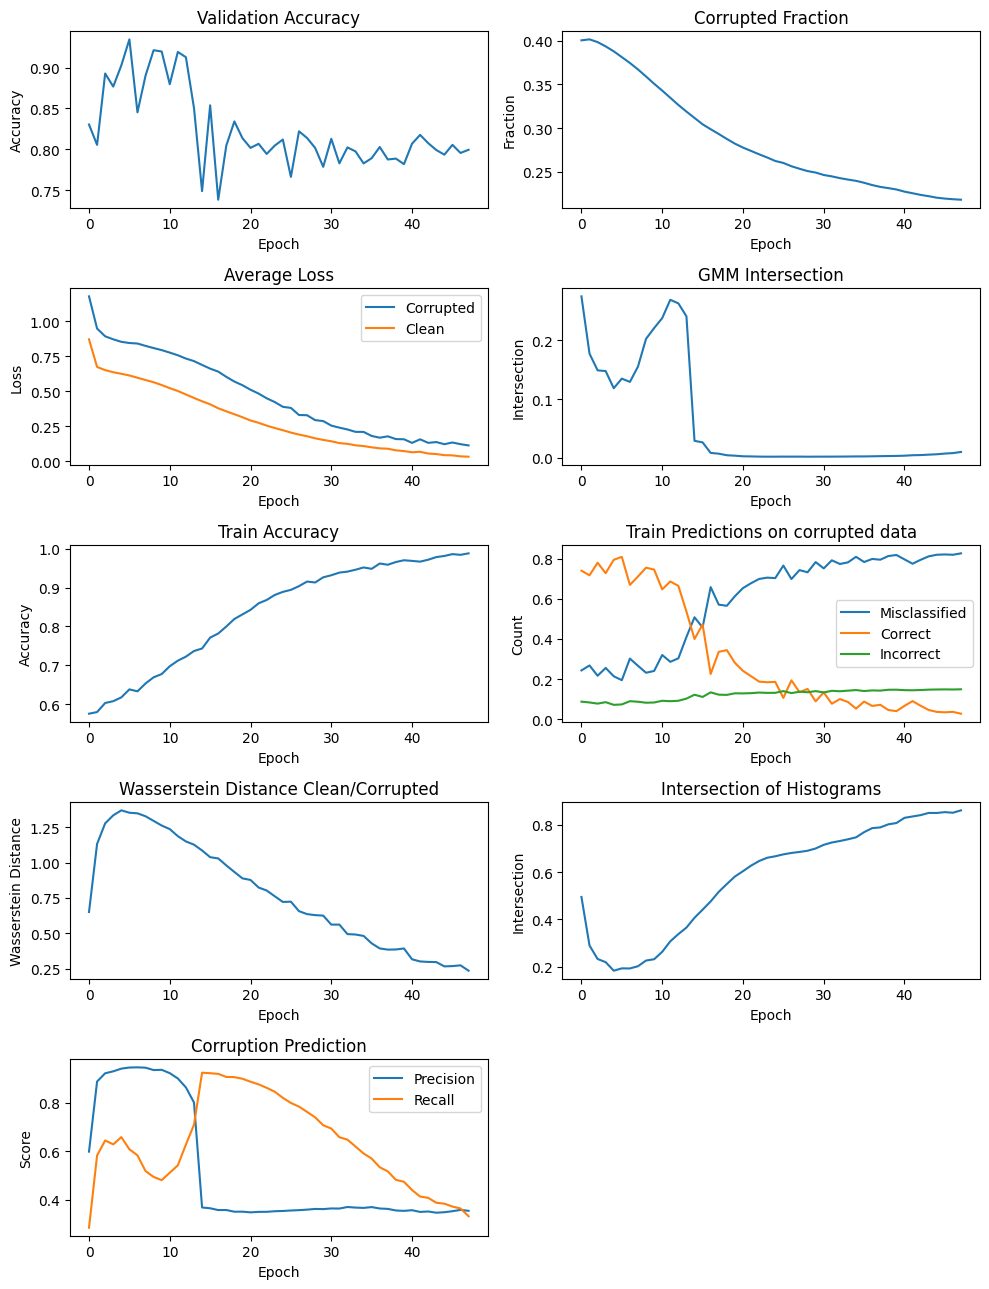

In [18]:
plot_insights('adamw_mnist_flip')

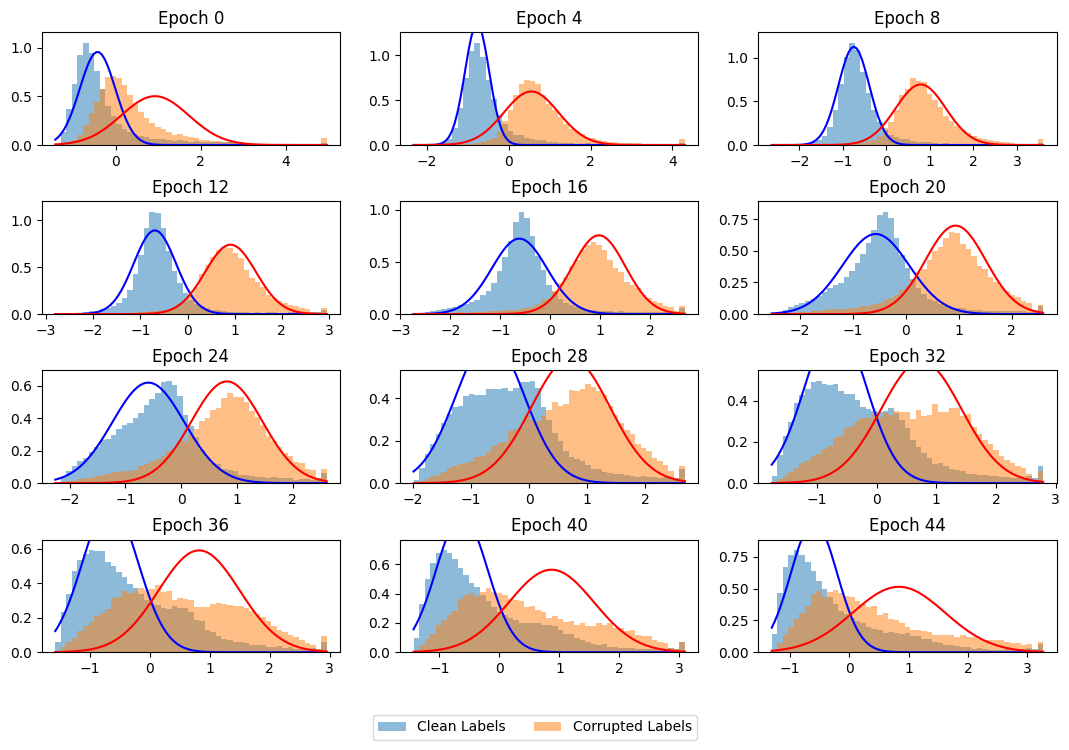

  0%|          | 0/48 [00:00<?, ?it/s]

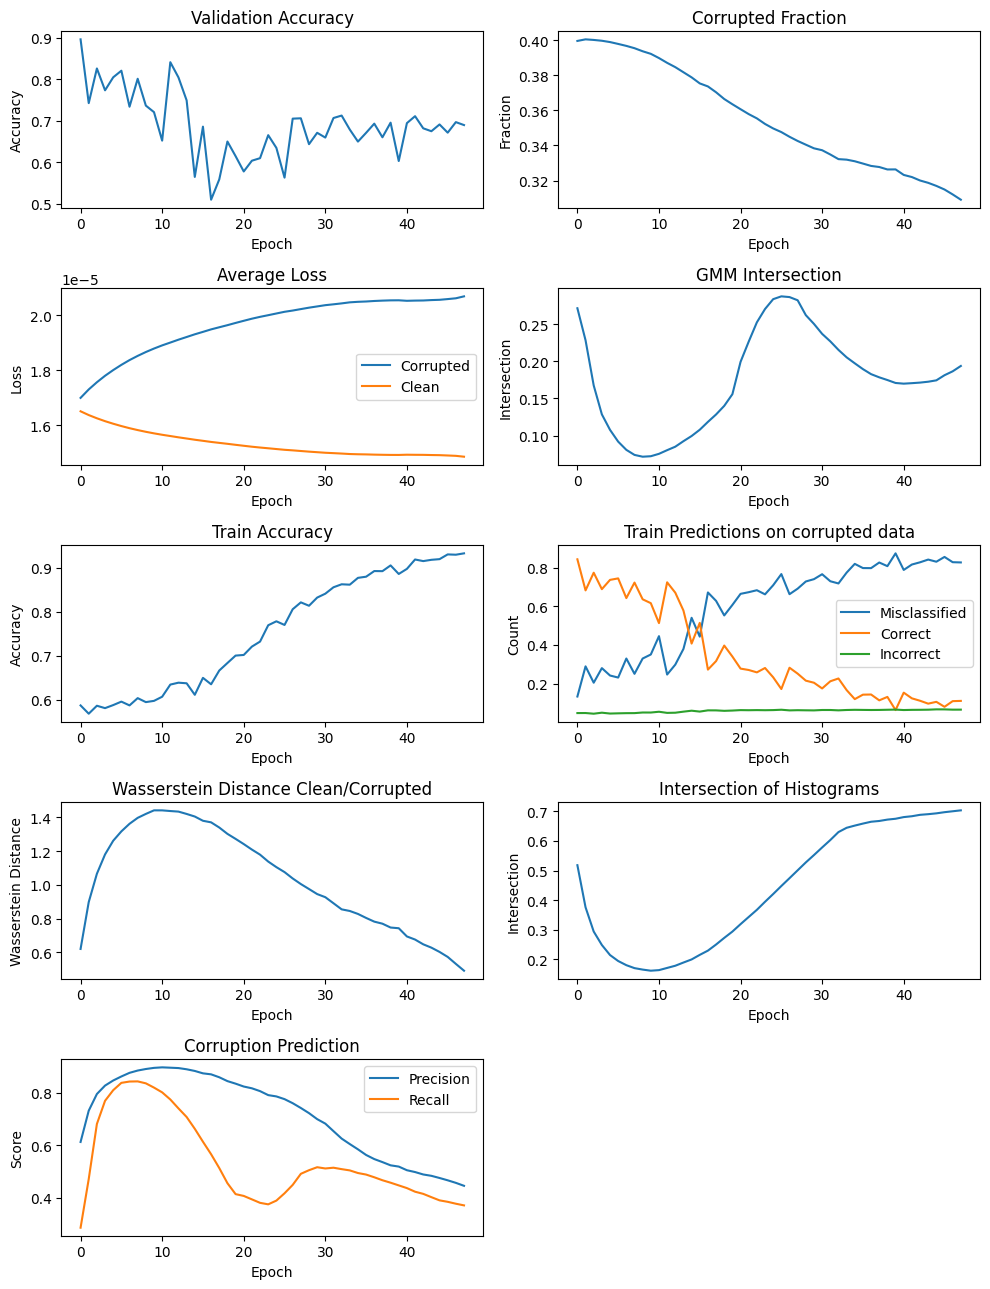

In [19]:
plot_insights('adversarial_mnist_flip')

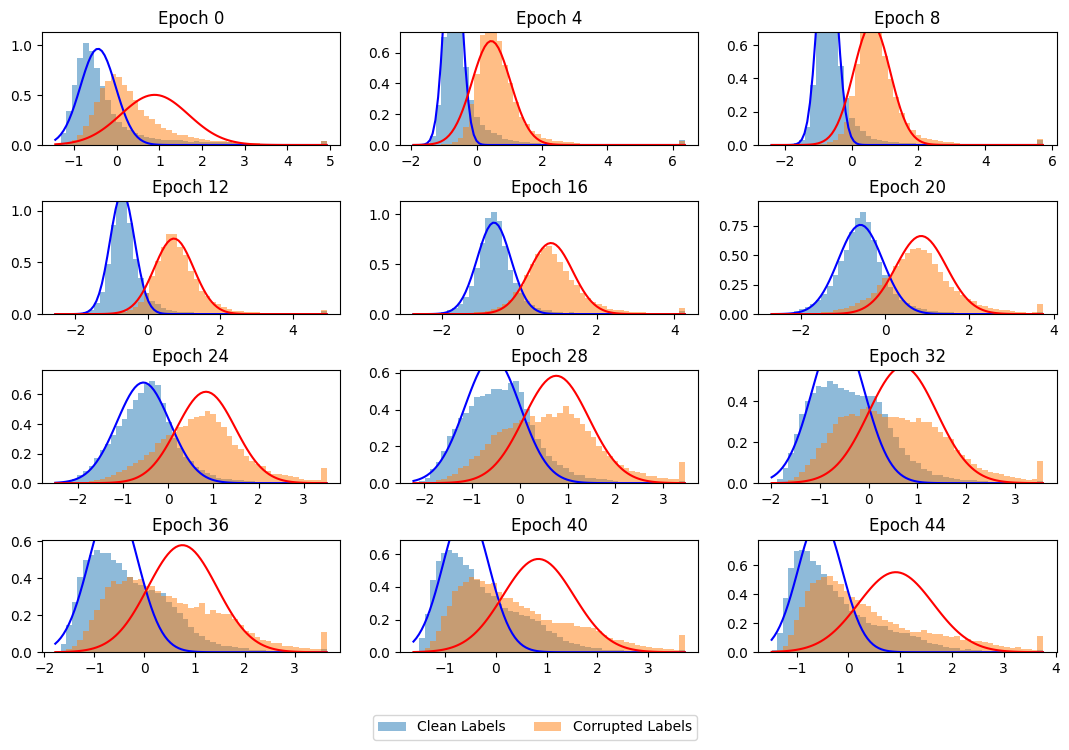

  0%|          | 0/48 [00:00<?, ?it/s]

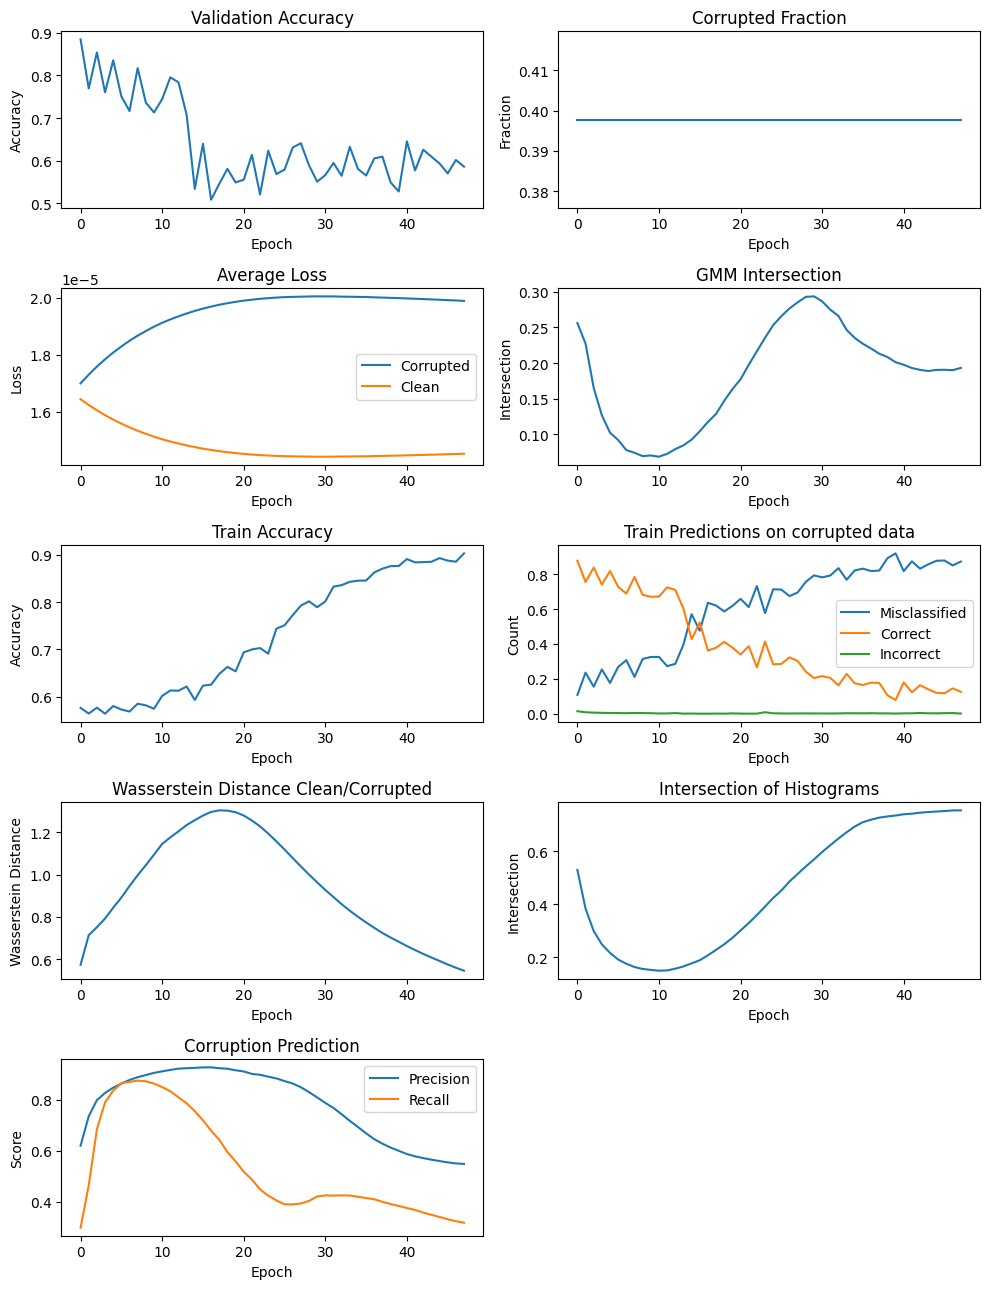

In [20]:
plot_insights('adversarial_mnist_base_faster_decay')

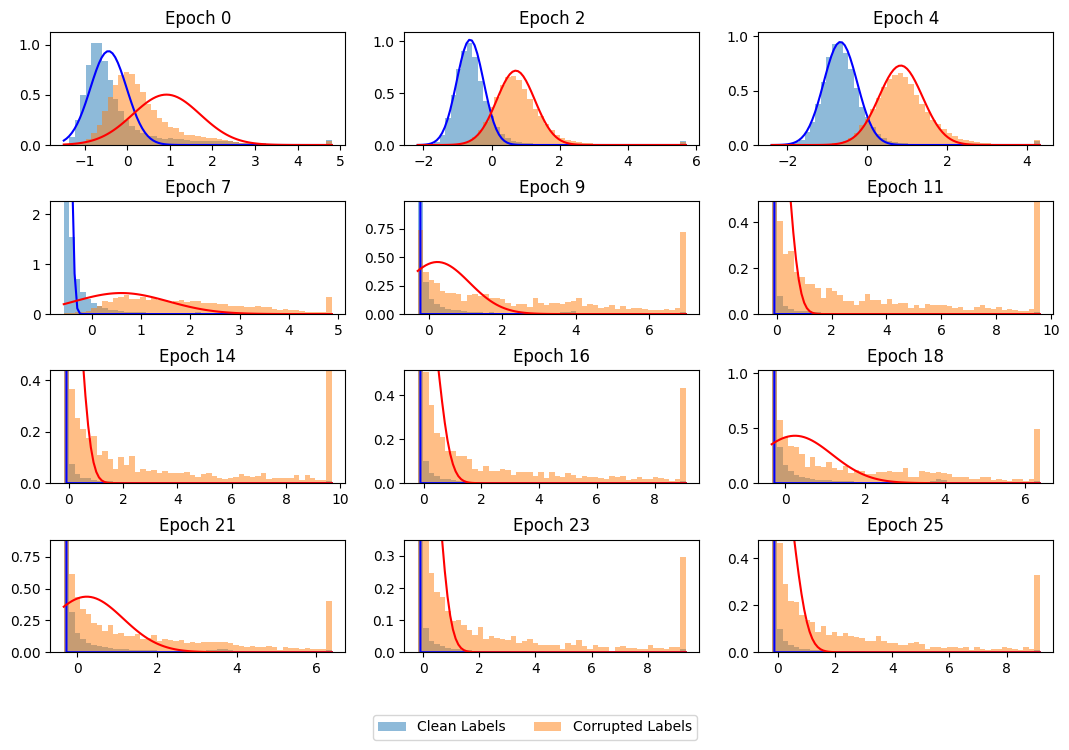

  0%|          | 0/28 [00:00<?, ?it/s]

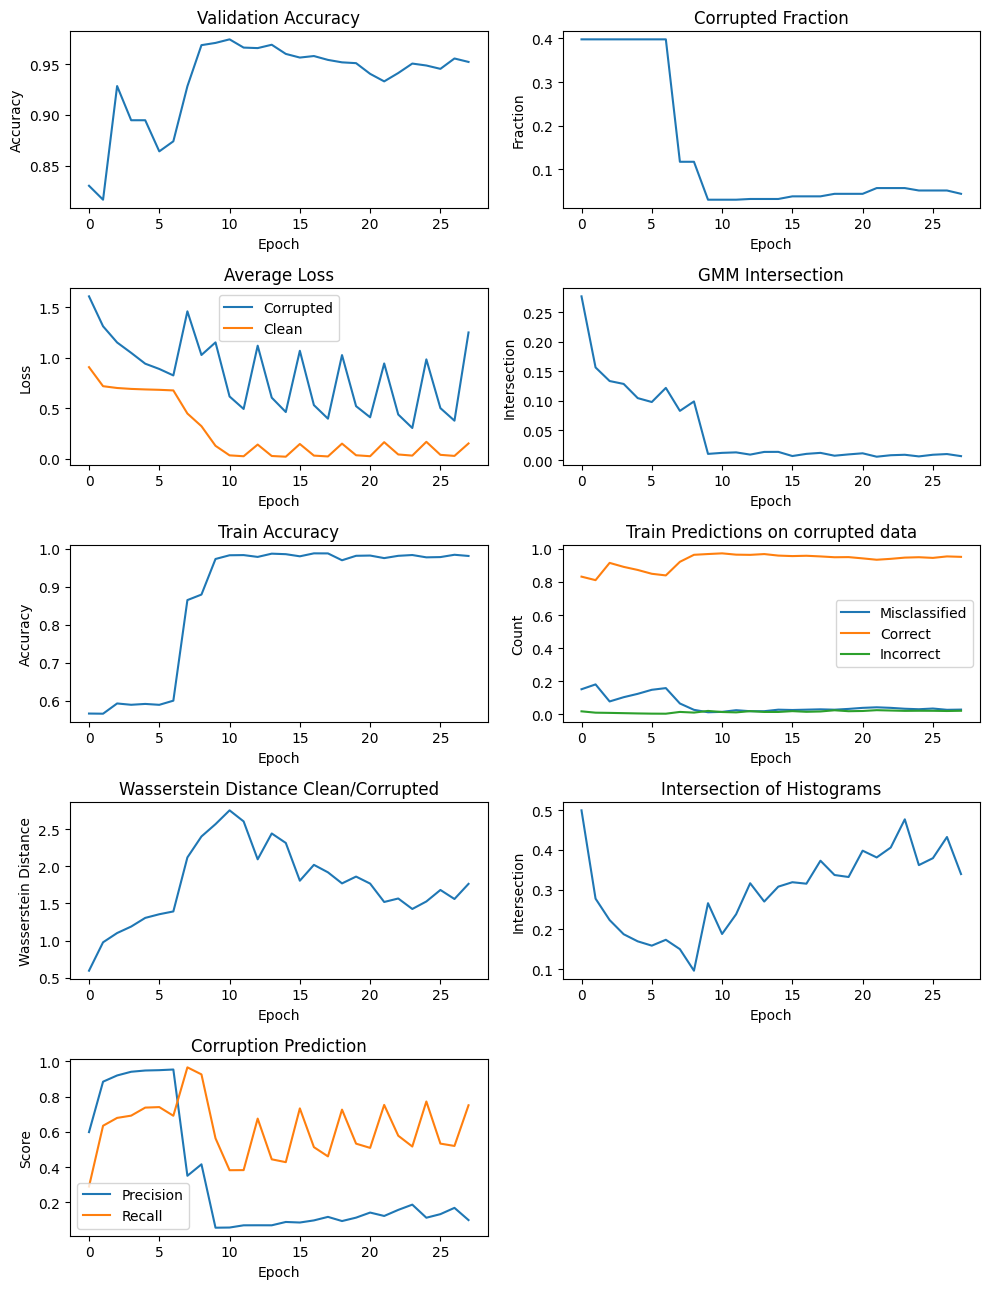

In [16]:
plot_insights('adamw_mnist_flip_gmm')

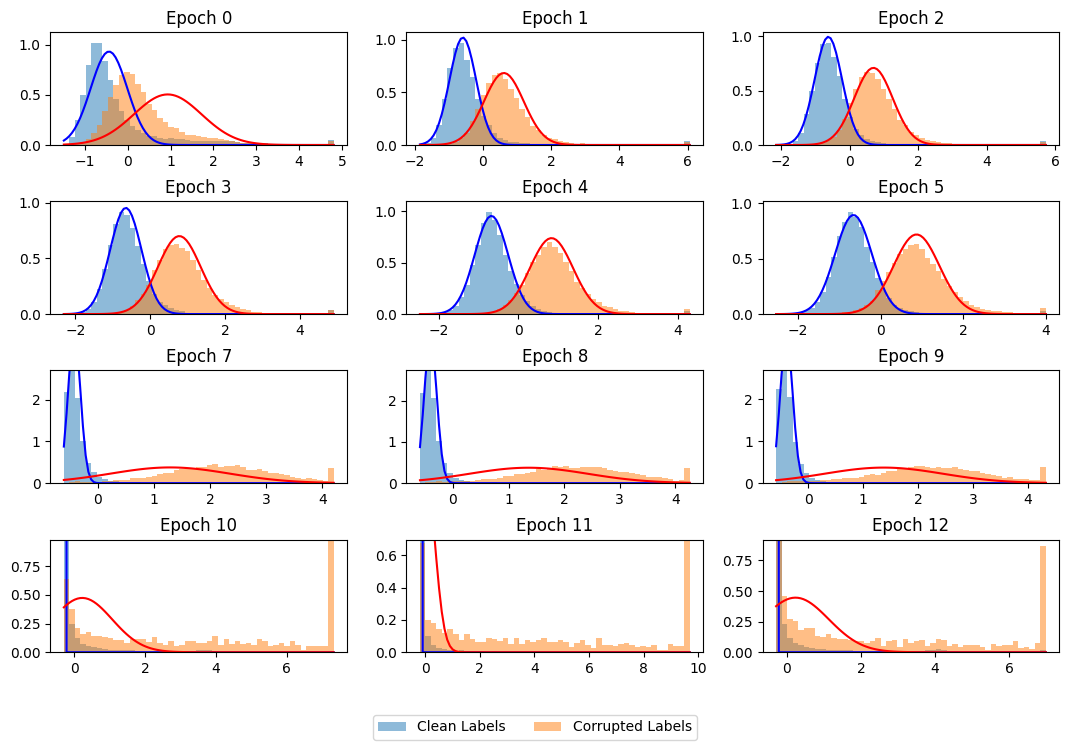

  0%|          | 0/14 [00:00<?, ?it/s]

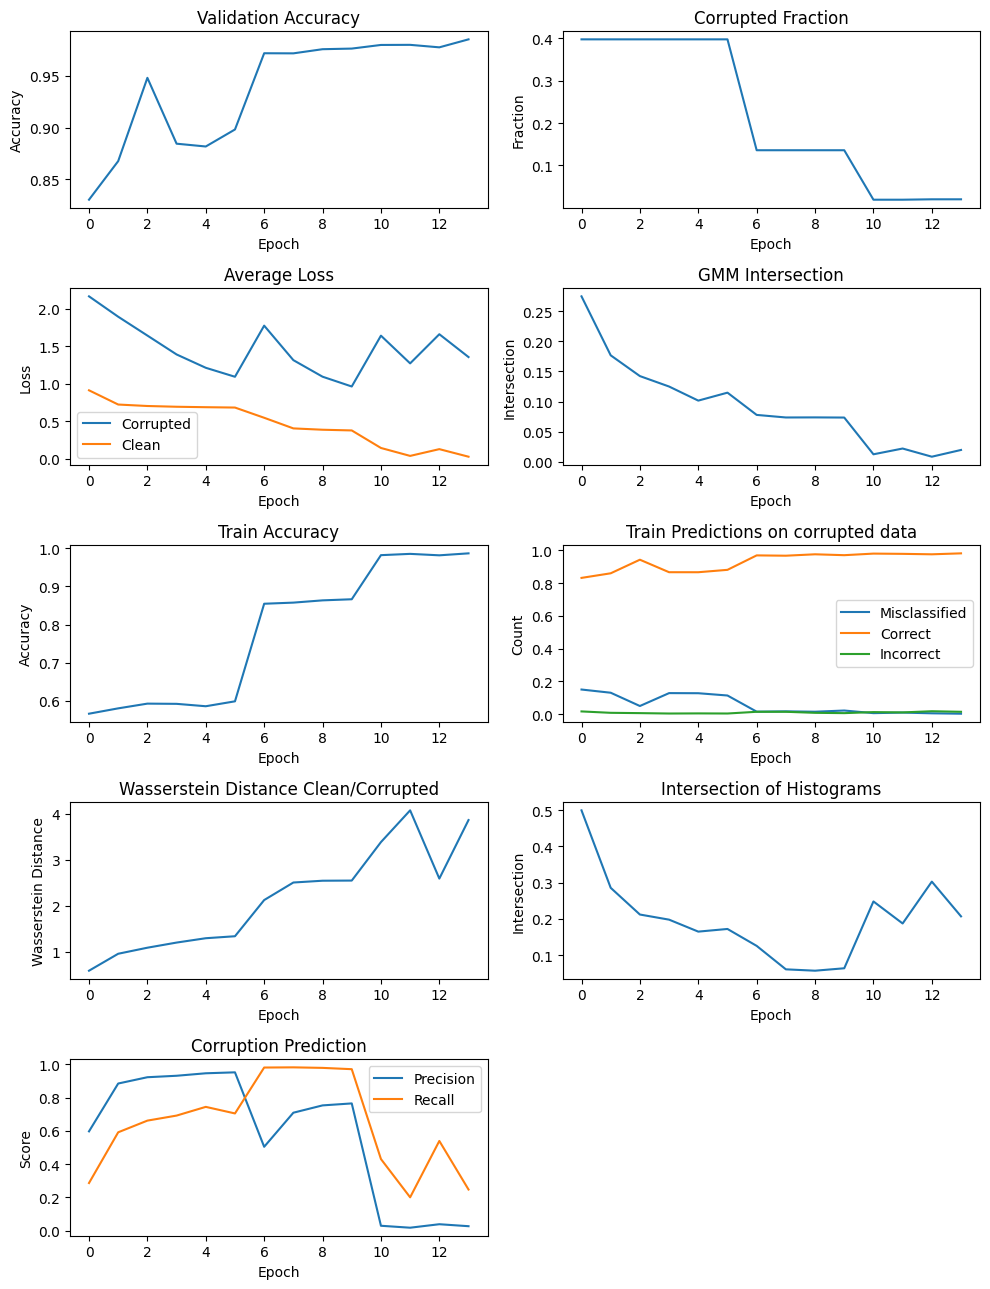

In [3]:
plot_insights('adamw_mnist_flip_gmm')

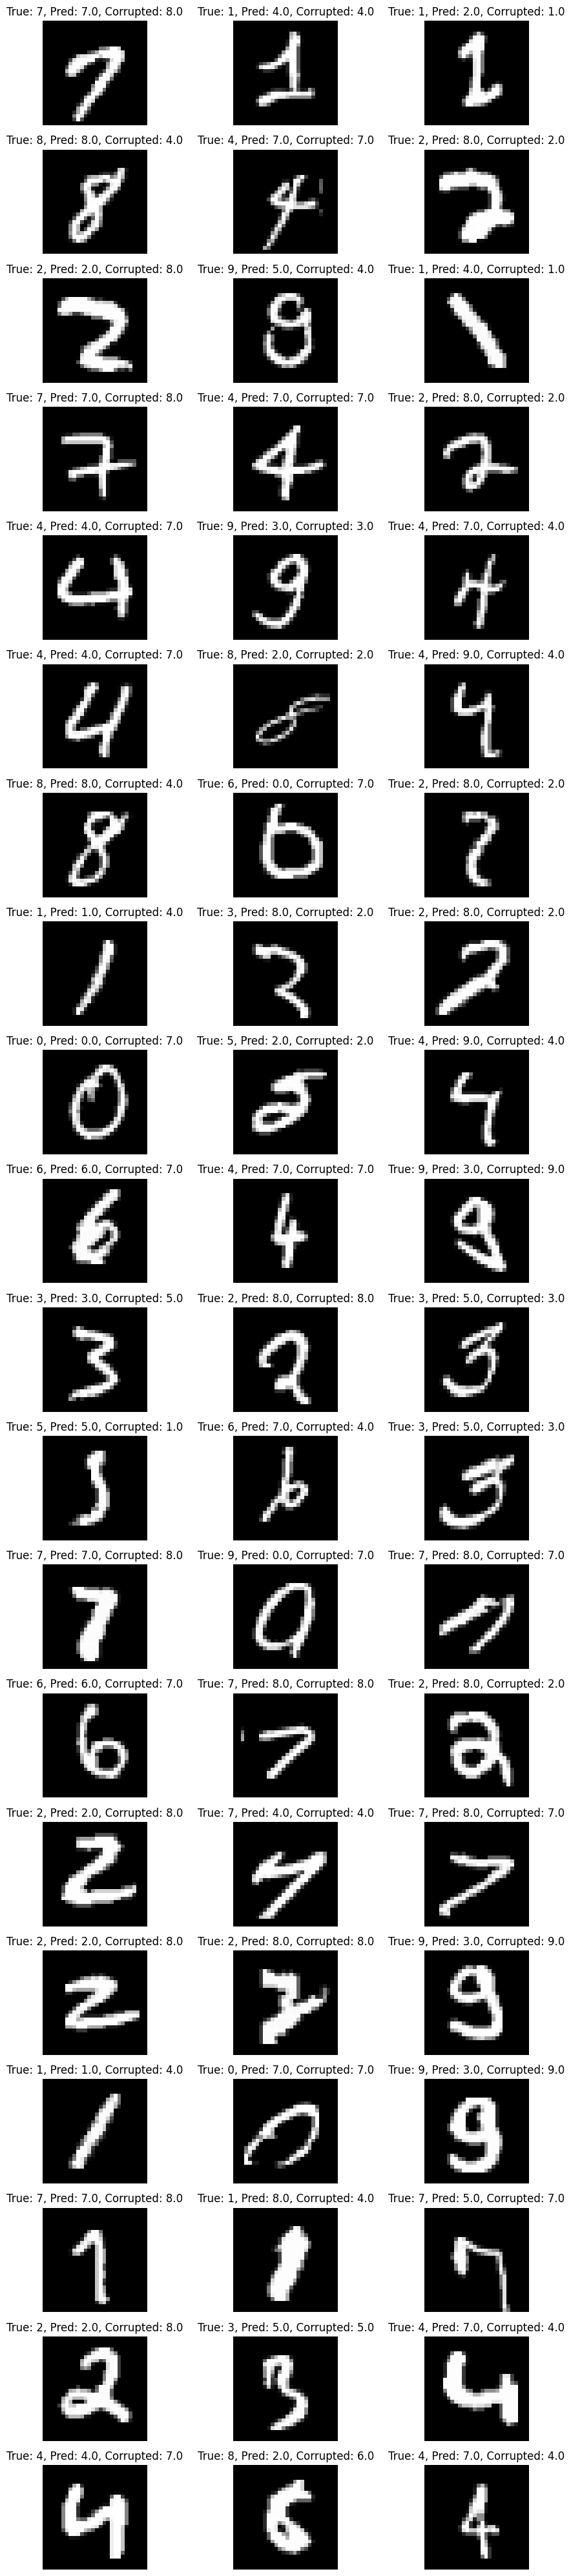

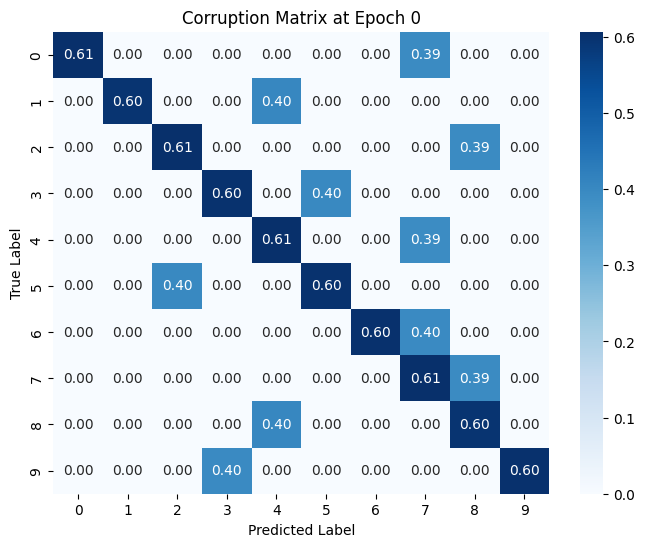

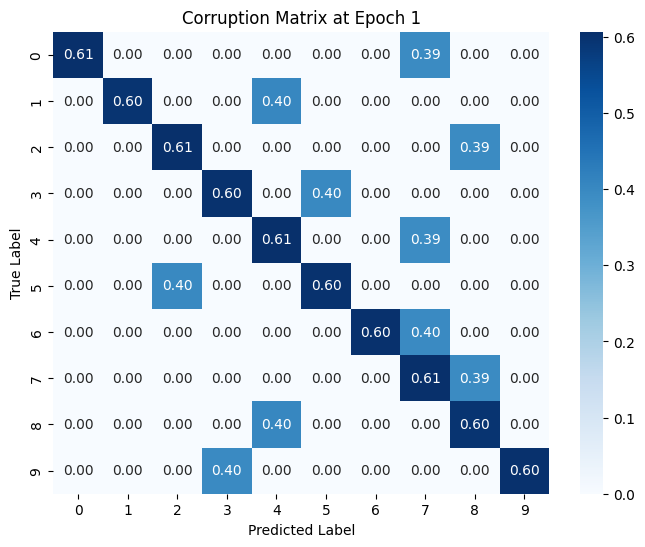

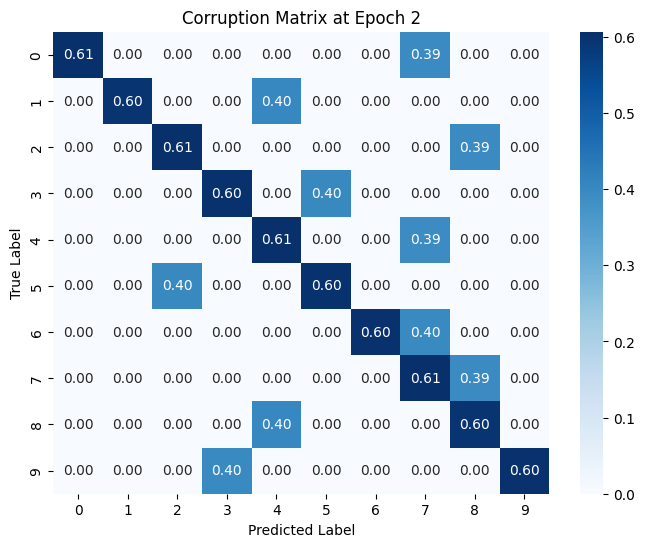

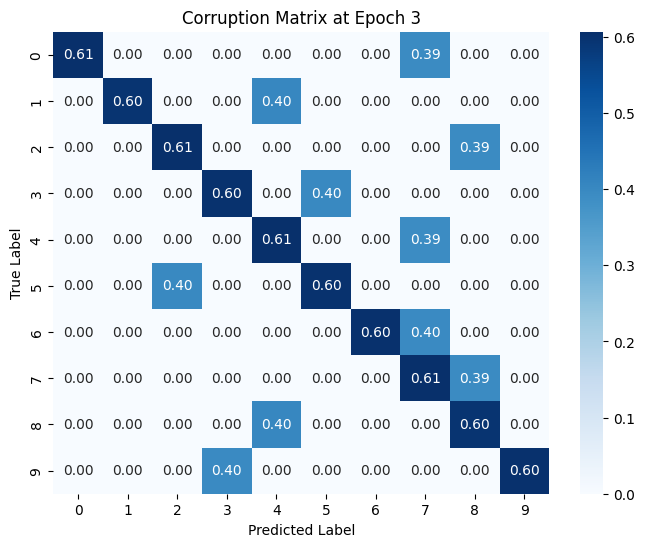

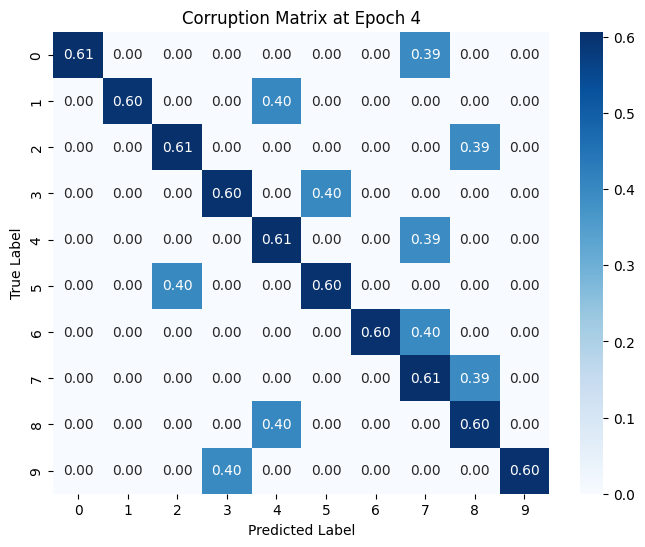

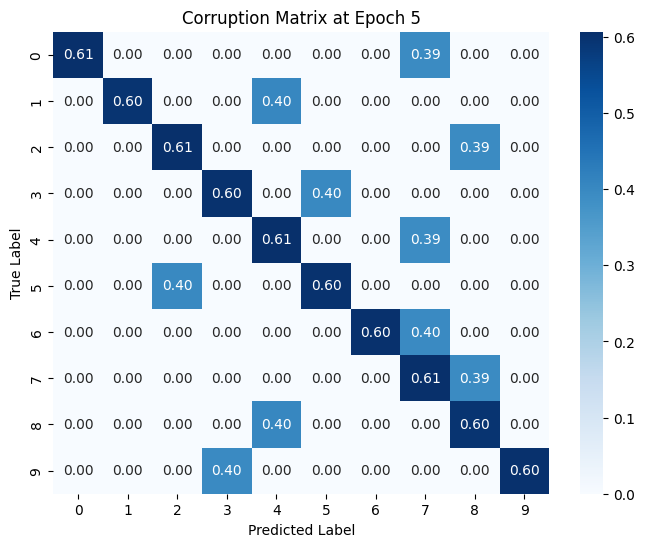

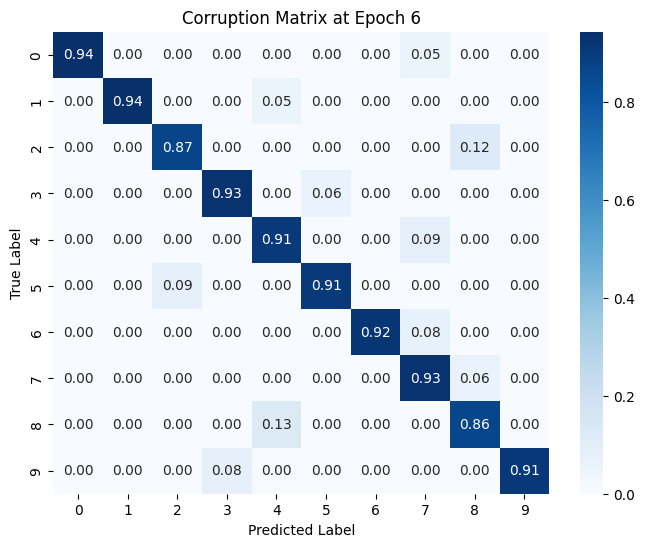

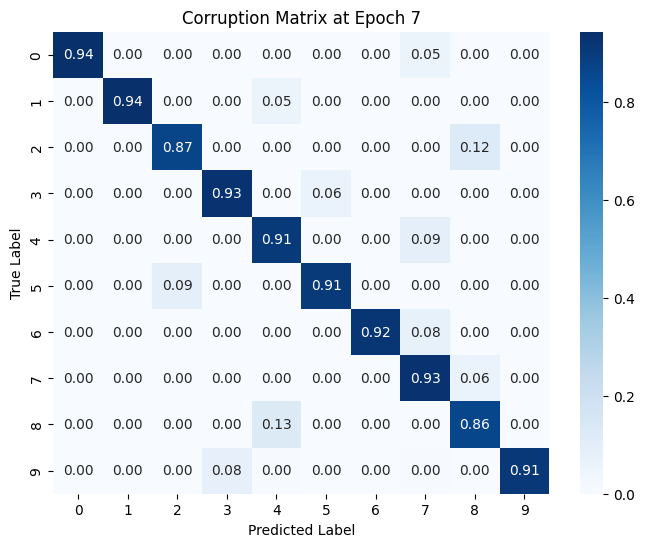

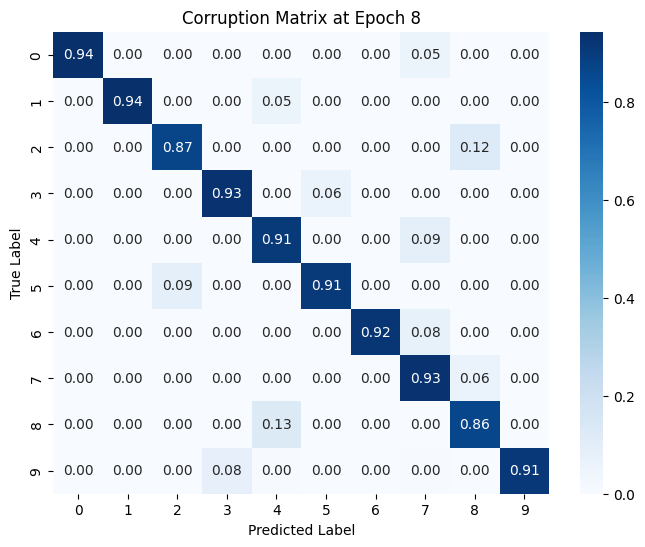

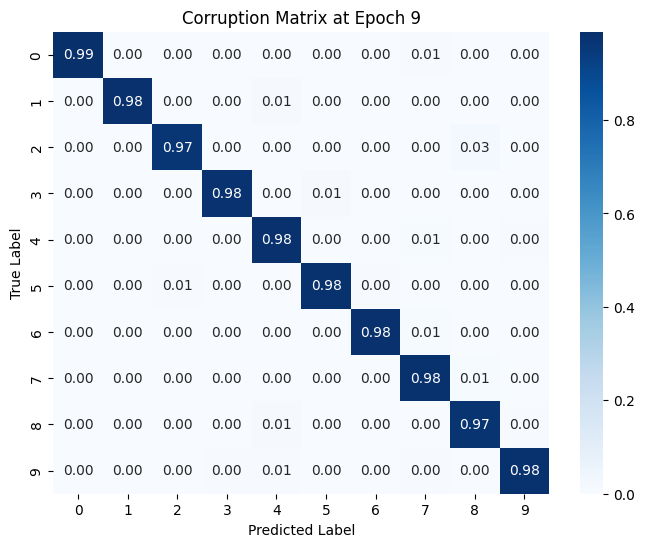

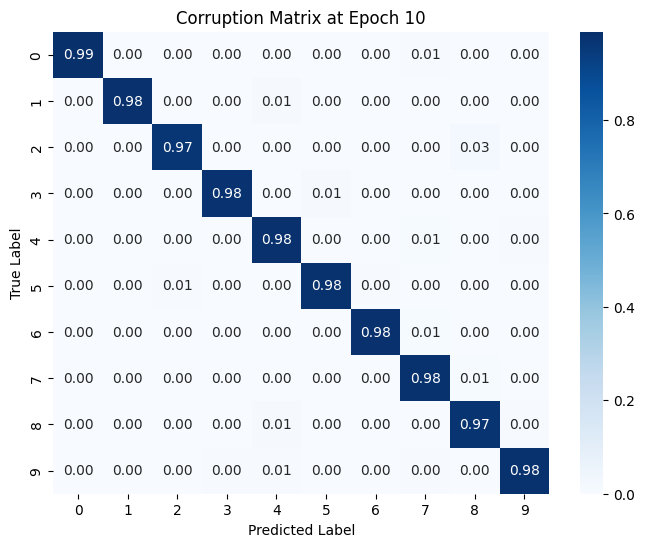

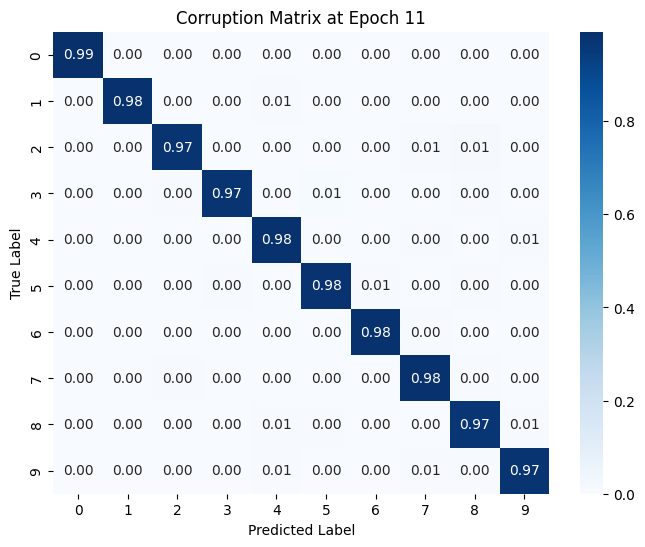

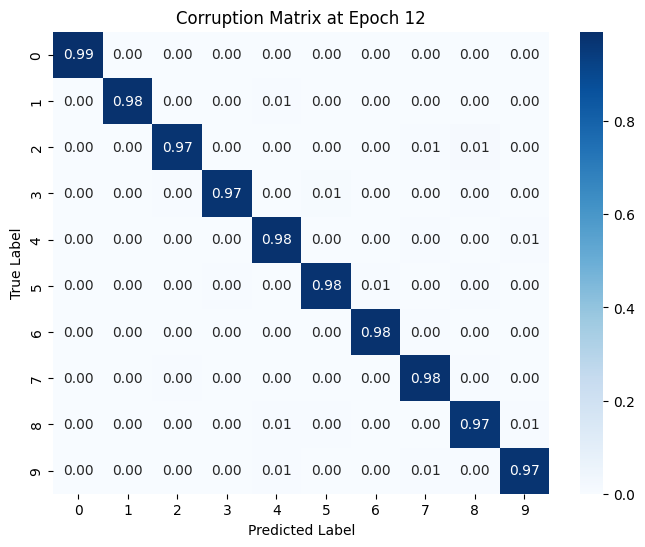

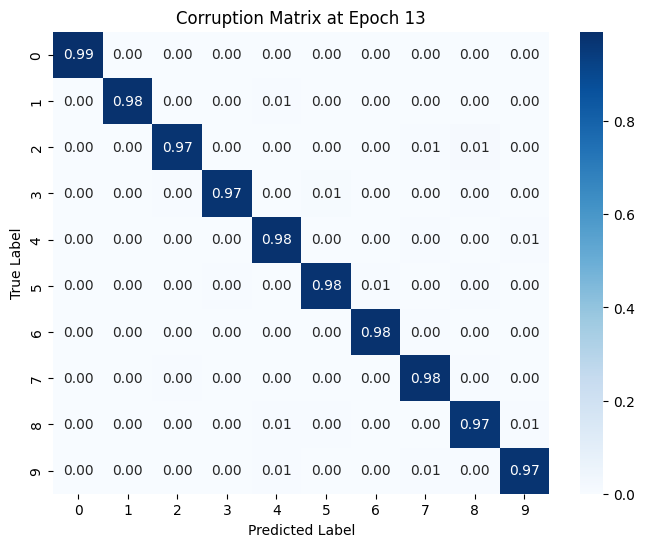

In [44]:
def analyze_corrections(directory: str):
    data = np.load(f"outputs/{directory}/losses.npy")
    epochs = 0
    for i in range(data.shape[0]):
        if np.count_nonzero(data[i]) > 0:
            epochs += 1
            
    data = data[:epochs, :]
    
    true_labels = np.load(f'outputs/{directory}/true_labels.npy')
    corrupted_labels = np.load(f'outputs/{directory}/corrupted_labels.npy')
    labels_history = np.load(f'outputs/{directory}/labels_history.npy')[:epochs, :]
    val_accuracies = np.load(f'outputs/{directory}/val_accuracies.npy')[:epochs]
    train_accuracies = np.load(f'outputs/{directory}/train_accuracies.npy')[:epochs]
    train_predictions = np.load(f'outputs/{directory}/train_predictions.npy')[:epochs, :]
    is_corrupted = corrupted_labels != true_labels
    
    # LOAD MNIST
    from torchvision import datasets, transforms
    dataset = datasets.MNIST(
        root='data',
        train=True,
        download=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    )
    
    
    epoch = 8
    scaled_data = data[epoch, :]
    clipped_data = np.clip(scaled_data, 0, np.quantile(scaled_data, 0.99))
    clipped_data = (clipped_data - np.mean(clipped_data)) / np.std(clipped_data)
    
    # Show some misclassified examples
    correct = np.where((train_predictions[epoch] == true_labels) & (labels_history[epoch] != true_labels))[0]
    misclassified = np.where((train_predictions[epoch] != true_labels) & (labels_history[epoch] != true_labels))[0]
    incorrect = np.where((train_predictions[epoch] != true_labels) & (labels_history[epoch] == true_labels))[0]
    
    fig, ax = plt.subplots(20, 3, figsize=(10, 40))
    for i in range(20):
        ax[i, 0].imshow(dataset.data[correct[i]], cmap='gray')
        ax[i, 0].set_title(f"True: {true_labels[correct[i]]}, Pred: {train_predictions[epoch][correct[i]]}, Corrupted: {labels_history[epoch][correct[i]]}")
        ax[i, 0].axis('off')
        
        ax[i, 1].imshow(dataset.data[misclassified[i]].numpy(), cmap='gray')
        ax[i, 1].set_title(f"True: {true_labels[misclassified[i]]}, Pred: {train_predictions[epoch][misclassified[i]]}, Corrupted: {labels_history[epoch][misclassified[i]]}")
        ax[i, 1].axis('off')
        
        ax[i, 2].imshow(dataset.data[incorrect[i]].numpy(), cmap='gray')
        ax[i, 2].set_title(f"True: {true_labels[incorrect[i]]}, Pred: {train_predictions[epoch][incorrect[i]]}, Corrupted: {labels_history[epoch][incorrect[i]]}")
        ax[i, 2].axis('off')
    plt.tight_layout()
    plt.show()
        
    
    for epoch in range(epochs):
    
        corruption_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(true_labels))))
        for i in range(len(true_labels)):
            corruption_matrix[true_labels[i], int(labels_history[epoch, i])] += 1
        corruption_matrix /= corruption_matrix.sum(axis=1, keepdims=True)
        
        import seaborn as sns
        plt.figure(figsize=(8, 6))
        sns.heatmap(corruption_matrix, annot=True, fmt=".2f", cmap='Blues')
        plt.title(f"Corruption Matrix at Epoch {epoch}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
        
        
analyze_corrections('adamw_mnist_flip_gmm')